# Mount Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Import library

In [2]:
import itertools

from tqdm import tqdm
import os
import cv2
import numpy as np

import tensorflow as tf
from tensorflow import keras
from keras import losses
from keras import layers, Sequential

from matplotlib import pyplot as plt

# Mendifinisikan class dan fungsi yang dibutuhkan

In [3]:
def load_data(path):

    images = []
    labels = []

    print("Loading {}".format(path))

    # Iterate through each folder corresponding to a category
    for i, folder in enumerate(os.listdir(path)):
        label = i
        for file in tqdm(os.listdir(os.path.join(path, folder))):

            # Get the path name of the image
            img_path = os.path.join(os.path.join(path, folder), file)

            # Open and resize the img
            image = cv2.imread(img_path, 1)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, (224, 224))

            # Append the image and its corresponding label to the output
            images.append(image)
            labels.append(label)

    images = np.array(images, dtype = np.uint8)
    labels = np.array(labels, dtype = np.uint8)

    return (images, labels)

## Googlenet

In [4]:
class Inception(keras.Model):
    def __init__(self, filters_1x1, filters_3x3_reduce, filters_3x3, filters_5x5_reduce, filters_5x5, filters_pool):
        super(Inception, self).__init__()

        self.path_1 = layers.Conv2D(filters_1x1, kernel_size=(1, 1), padding='same', activation='relu')
        self.path_2 = Sequential([
            layers.Conv2D(filters_3x3_reduce, kernel_size=(1, 1), padding='same', activation='relu'),
            layers.Conv2D(filters_3x3, kernel_size=(3, 3), padding='same', activation='relu')
        ])
        self.path_3 = Sequential([
            layers.Conv2D(filters_5x5_reduce, (1, 1), padding='same', activation='relu'),
            layers.Conv2D(filters_5x5, (5, 5), padding='same', activation='relu')
        ])
        self.path_4 = Sequential([
            layers.MaxPool2D((3, 3), strides=(1, 1), padding='same'),
            layers.Conv2D(filters_pool, (1, 1), padding='same', activation='relu')
        ])

    def call(self, x):
        path1 = self.path_1(x)
        path2 = self.path_2(x)
        path3 = self.path_3(x)
        path4 = self.path_4(x)
        return layers.concatenate(inputs=[path1, path2, path3, path4], axis=3)

class Googlenet(keras.Model):
    def __init__(self):
        super(Googlenet, self).__init__()

        self.sequential_1 = Sequential([
            layers.Conv2D(filters=64, kernel_size=7, strides=2, padding='same', activation='relu'),
            layers.MaxPooling2D(3, strides=2),
            layers.Conv2D(64, 1, strides=1, padding='same', activation='relu'),
            layers.Conv2D(192, 3, strides=1, padding='same', activation='relu'),
            layers.MaxPooling2D(3, strides=2),
            Inception(filters_1x1=64, filters_3x3_reduce=96, filters_3x3=128,
                      filters_5x5_reduce=16, filters_5x5=32, filters_pool=32),
            Inception(filters_1x1=128, filters_3x3_reduce=128, filters_3x3=192,
                      filters_5x5_reduce=32, filters_5x5=96, filters_pool=64),
            layers.MaxPooling2D(3, strides=2),
            Inception(filters_1x1=192, filters_3x3_reduce=96, filters_3x3=208,
                      filters_5x5_reduce=16, filters_5x5=48, filters_pool=64),
        ])
        self.aux_1 = Sequential([
            layers.AveragePooling2D((5, 5), strides=3),
            layers.Conv2D(128, 1, padding='same', activation='relu'),
            layers.Flatten(),
            layers.Dense(1024, activation='relu'),
            layers.Dropout(0.7),
            layers.Dense(4, activation='softmax'),
        ])
        self.sequential_2 = Sequential([
            Inception(filters_1x1=160, filters_3x3_reduce=112, filters_3x3=224, filters_5x5_reduce=24, filters_5x5=64, filters_pool=64),
            Inception(filters_1x1=128, filters_3x3_reduce=128, filters_3x3=256, filters_5x5_reduce=24, filters_5x5=64, filters_pool=64),
            Inception(filters_1x1=112, filters_3x3_reduce=144, filters_3x3=288, filters_5x5_reduce=32, filters_5x5=64, filters_pool=64)
        ])
        self.aux_2 = Sequential([
            layers.AveragePooling2D((5, 5), strides=3),
            layers.Conv2D(128, 1, padding='same', activation='relu'),
            layers.Flatten(),
            layers.Dense(1024, activation='relu'),
            layers.Dropout(0.7),
            layers.Dense(4, activation='softmax')
        ])
        self.aux_3 = Sequential([
            Inception(filters_1x1=256, filters_3x3_reduce=160, filters_3x3=320, filters_5x5_reduce=32, filters_5x5=128, filters_pool=128),
            layers.MaxPooling2D(3, strides=2),
            Inception(filters_1x1=256, filters_3x3_reduce=160, filters_3x3=320, filters_5x5_reduce=32, filters_5x5=128, filters_pool=128),
            Inception(filters_1x1=384, filters_3x3_reduce=192, filters_3x3=384, filters_5x5_reduce=48, filters_5x5=128, filters_pool=128),
            layers.GlobalAveragePooling2D(),
            layers.Dropout(0.4),
            layers.Dense(4, activation='softmax')
        ])
    def call(self, x):
        x       = self.sequential_1(x)
        aux_1   = self.aux_1(x)
        x       = self.sequential_2(x)
        aux_2   = self.aux_2(x)
        x       = self.aux_3(x)
        return {'result':x, 'aux_1':aux_1, 'aux_2':aux_2}

## Fungsi plot history accuracy dan loss

In [5]:
def plot_history(loss, val_loss, acc, val_acc):
    fig, axs = plt.subplots(2, 1, figsize=(10,10))

    axs[0].plot(loss)
    axs[0].plot(val_loss)
    axs[0].title.set_text('Training Loss vs Validation Loss')
    axs[0].set_xlabel('Epochs')
    axs[0].set_ylabel('Loss')
    axs[0].legend(['Train','Val'])

    axs[1].plot(acc)
    axs[1].plot(val_acc)
    axs[1].title.set_text('Training Accuracy vs Validation Accuracy')
    axs[1].set_xlabel('Epochs')
    axs[1].set_ylabel('Accuracy')
    axs[1].legend(['Train', 'Val'])

## Fungsi plot confusion matrix

In [6]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Data citra original

In [7]:
X_train, y_train = load_data("/content/drive/MyDrive/SKRIPSI/dataset/original/train")
X_train = tf.convert_to_tensor(X_train / 255, dtype=tf.float32)

X_val, y_val = load_data("/content/drive/MyDrive/SKRIPSI/dataset/original/val")
X_val = tf.convert_to_tensor(X_val / 255, dtype=tf.float32)

Loading /content/drive/MyDrive/SKRIPSI/dataset/original/train


100%|██████████| 643/643 [00:06<00:00, 97.98it/s] 


Loading /content/drive/MyDrive/SKRIPSI/dataset/original/val


100%|██████████| 80/80 [00:00<00:00, 93.58it/s]


## membuat model

In [8]:
model = Googlenet()

In [9]:
model.compile(optimizer='adam',
    loss=[
        losses.sparse_categorical_crossentropy,
        losses.sparse_categorical_crossentropy,
        losses.sparse_categorical_crossentropy
    ],
    loss_weights=[1, 0.3, 0.3],
    metrics=['accuracy', 'accuracy', 'accuracy'])
history = model.fit(X_train, [y_train, y_train, y_train], validation_data=(X_val, [y_val, y_val, y_val]), batch_size=64, epochs=20)

Epoch 1/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 107s 1s/step - aux_1_accuracy: 0.3517 - aux_1_loss: 1.3379 - aux_2_accuracy: 0.3216 - aux_2_loss: 0.4056 - loss: 2.1517 - result_accuracy: 0.3088 - result_loss: 0.4081 - val_aux_1_accuracy: 0.6883 - val_aux_1_loss: 0.9887 - val_aux_2_accuracy: 0.5370 - val_aux_2_loss: 0.3103 - val_loss: 1.7051 - val_result_accuracy: 0.5401 - val_result_loss: 0.3360
Epoch 2/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 65s 219ms/step - aux_1_accuracy: 0.6819 - aux_1_loss: 0.7911 - aux_2_accuracy: 0.6243 - aux_2_loss: 0.2584 - loss: 1.3264 - result_accuracy: 0.5836 - result_loss: 0.2770 - val_aux_1_accuracy: 0.7562 - val_aux_1_loss: 0.4963 - val_aux_2_accuracy: 0.7623 - val_aux_2_loss: 0.1440 - val_loss: 0.9321 - val_result_accuracy: 0.7809 - val_result_loss: 0.1494
Epoch 3/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 10s 213ms/step - aux_1_accuracy: 0.7467 - aux_1_loss: 0.5507 - aux_2_accuracy: 0.7620 - aux_2_loss: 0.1627 - loss: 0.8803 - result_accuracy: 0.7422 - result_loss: 0.1674 - val_aux_1_

## plot history

In [11]:
history.history.keys()

dict_keys(['aux_1_accuracy', 'aux_1_loss', 'aux_2_accuracy', 'aux_2_loss', 'loss', 'result_accuracy', 'result_loss', 'val_aux_1_accuracy', 'val_aux_1_loss', 'val_aux_2_accuracy', 'val_aux_2_loss', 'val_loss', 'val_result_accuracy', 'val_result_loss'])

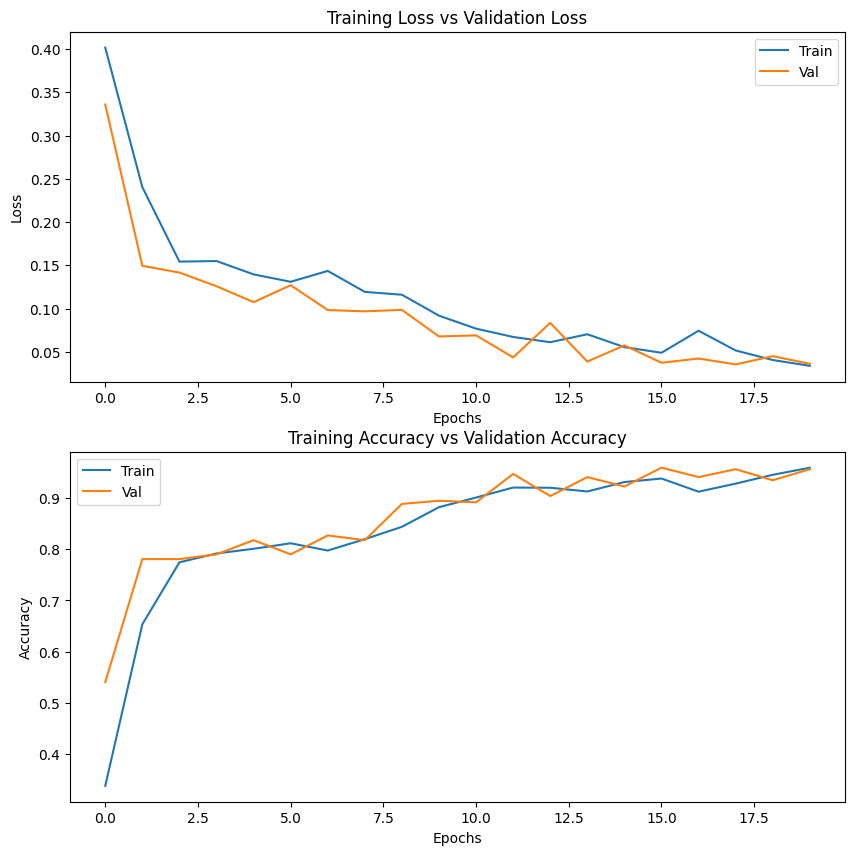

In [12]:
plot_history(history.history['result_loss'], history.history['val_result_loss'], history.history['result_accuracy'], history.history['val_result_accuracy'])

## confusion matrix

Loading /content/drive/MyDrive/SKRIPSI/dataset/original/test


100%|██████████| 81/81 [00:00<00:00, 157.10it/s]


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


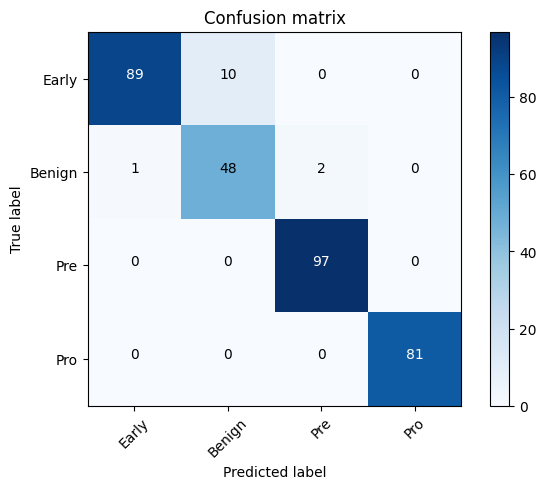

In [14]:
# Load data test
X_test, y_test = load_data("/content/drive/MyDrive/SKRIPSI/dataset/original/test")
X_test = tf.convert_to_tensor(X_test / 255, dtype=tf.float32)

# predict data test
y_pred = model.predict(X_test)
y_pred = tf.math.argmax(y_pred['result'], axis=1)

cm_data = tf.math.confusion_matrix(y_test, y_pred)

classes = os.listdir("/content/drive/MyDrive/SKRIPSI/dataset/original/train")

plot_confusion_matrix(cm_data.numpy(), classes)

## menyimpan model

In [15]:
os.makedirs("/content/drive/MyDrive/SKRIPSI/streamlit/googlenet_model", exist_ok=True)
os.makedirs("/content/drive/MyDrive/SKRIPSI/streamlit/googlenet_model/original_data", exist_ok=True)

tf.saved_model.save(model, "/content/drive/MyDrive/SKRIPSI/streamlit/googlenet_model/original_data")

# Data citra CLAHE

In [7]:
X_train, y_train = load_data("/content/drive/MyDrive/SKRIPSI/dataset/clahe/train")
X_train = tf.convert_to_tensor(X_train / 255, dtype=tf.float32)

X_val, y_val = load_data("/content/drive/MyDrive/SKRIPSI/dataset/clahe/val")
X_val = tf.convert_to_tensor(X_val / 255, dtype=tf.float32)

Loading /content/drive/MyDrive/SKRIPSI/dataset/clahe/train


100%|██████████| 643/643 [00:05<00:00, 109.28it/s]


Loading /content/drive/MyDrive/SKRIPSI/dataset/clahe/val


100%|██████████| 80/80 [00:20<00:00,  3.82it/s]


## membuat model

In [8]:
model = Googlenet()

model.compile(optimizer='adam',
    loss=[
        losses.sparse_categorical_crossentropy,
        losses.sparse_categorical_crossentropy,
        losses.sparse_categorical_crossentropy
    ],
    loss_weights=[1, 0.3, 0.3],
    metrics=['accuracy', 'accuracy', 'accuracy']
)
history = model.fit(X_train, [y_train, y_train, y_train], validation_data=(X_val, [y_val, y_val, y_val]), batch_size=64, epochs=20)

Epoch 1/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 101s 1s/step - aux_1_accuracy: 0.3325 - aux_1_loss: 1.3433 - aux_2_accuracy: 0.3209 - aux_2_loss: 0.4111 - loss: 2.1747 - result_accuracy: 0.3076 - result_loss: 0.4202 - val_aux_1_accuracy: 0.5031 - val_aux_1_loss: 1.1976 - val_aux_2_accuracy: 0.5216 - val_aux_2_loss: 0.3868 - val_loss: 2.0126 - val_result_accuracy: 0.3765 - val_result_loss: 0.3925
Epoch 2/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 11s 211ms/step - aux_1_accuracy: 0.5471 - aux_1_loss: 0.9618 - aux_2_accuracy: 0.5542 - aux_2_loss: 0.3136 - loss: 1.5868 - result_accuracy: 0.5546 - result_loss: 0.3113 - val_aux_1_accuracy: 0.7716 - val_aux_1_loss: 0.4988 - val_aux_2_accuracy: 0.6698 - val_aux_2_loss: 0.1862 - val_loss: 1.0736 - val_result_accuracy: 0.5833 - val_result_loss: 0.2317
Epoch 3/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 9s 215ms/step - aux_1_accuracy: 0.7809 - aux_1_loss: 0.5200 - aux_2_accuracy: 0.7836 - aux_2_loss: 0.1547 - loss: 0.8412 - result_accuracy: 0.7651 - result_loss: 0.1667 - val_aux_1_a

## plot history

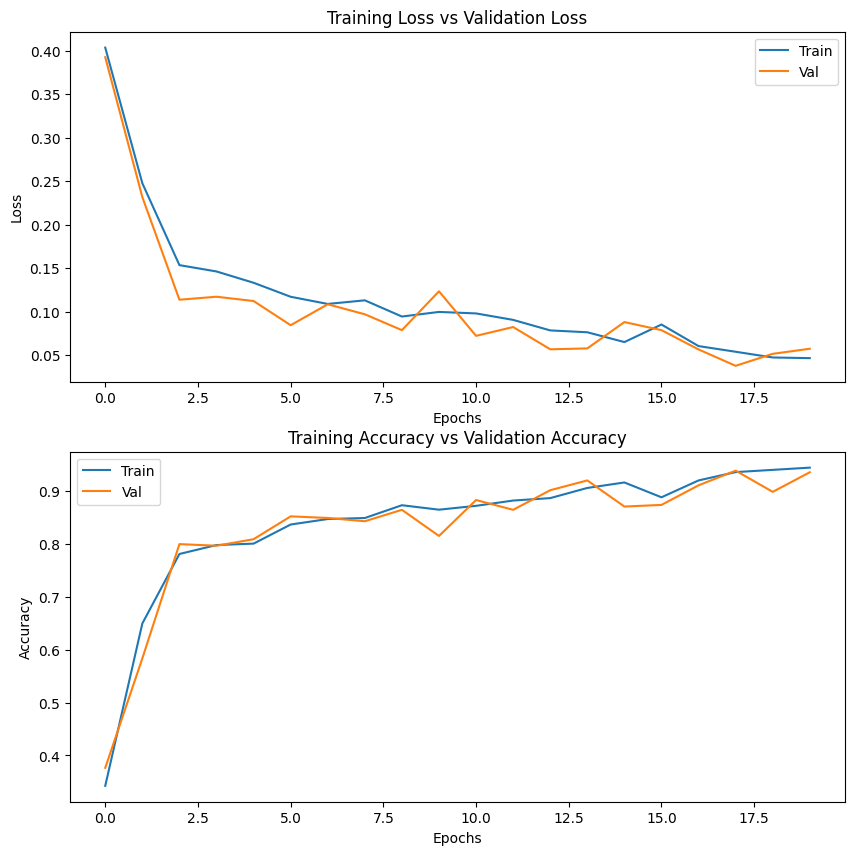

In [9]:
plot_history(history.history['result_loss'], history.history['val_result_loss'], history.history['result_accuracy'], history.history['val_result_accuracy'])

## confusion matrix

Loading /content/drive/MyDrive/SKRIPSI/dataset/clahe/test


100%|██████████| 81/81 [00:17<00:00,  4.63it/s]


11/11 ━━━━━━━━━━━━━━━━━━━━ 12s 578ms/step


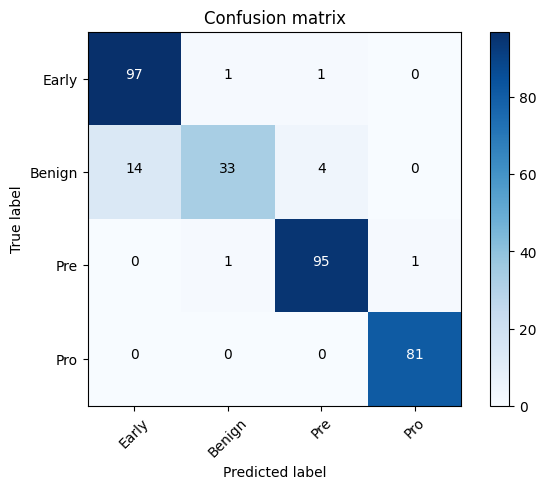

In [10]:
# Load data test
X_test, y_test = load_data("/content/drive/MyDrive/SKRIPSI/dataset/clahe/test")
X_test = tf.convert_to_tensor(X_test / 255, dtype=tf.float32)

#predict data test
y_pred = model.predict(X_test)
y_pred = tf.math.argmax(y_pred['result'], axis=1)

cm_data = tf.math.confusion_matrix(y_test, y_pred).numpy()

classes = os.listdir("/content/drive/MyDrive/SKRIPSI/dataset/original/train")

plot_confusion_matrix(cm_data, classes)

## menyimpan model

In [11]:
os.makedirs("/content/drive/MyDrive/SKRIPSI/streamlit/googlenet_model", exist_ok=True)
os.makedirs("/content/drive/MyDrive/SKRIPSI/streamlit/googlenet_model/clahe_data", exist_ok=True)

tf.saved_model.save(model, "/content/drive/MyDrive/SKRIPSI/streamlit/googlenet_model/clahe_data")